# Imports

In [17]:
from setup import *
from genetic_algorithm import create_roadmap, calculate_fitness, crossover, mutate

import random
import pandas as pd
from itertools import product

# Parametros

In [18]:
population_sizes = [3, 5, 7]
n_generations_list = [50, 100, 150]
crossover_methods = [CrossoverMethod.OX1, CrossoverMethod.OX2, CrossoverMethod.CX]
mutation_methods = [MutateMethod.SWAP, MutateMethod.INSERTION, MutateMethod.INVERSION, MutateMethod.SHUFFLE]
mutation_probabilities = [0.05, 0.1, 0.2]

# Funções

In [19]:
# Identifica a melhor solução dados os paramêtros
def get_winner_genetic_algorithm(
        population_size: int,
        n_generations: int,
        crossover_method: CrossoverMethod,
        mutation_method: MutateMethod, 
        mutation_probability: float) -> dict:
    winner = {
        'generation': None,
        'best_fitness': None,
        'solution': None
    }
    generation = 0
    population = [create_roadmap(ATTRACTIONS) for _ in range(population_size)] 
    best_fitness_values = []
    best_solutions = []
    for generation in range(n_generations):
        population.sort(key=lambda it: calculate_fitness(it, BUDGET_MAX), reverse=False)

        new_population = [population[0]]

        best_fitness = calculate_fitness(population[0], BUDGET_MAX)
        best_solution = population[0]

        if(best_solution != winner["solution"]):
            winner['generation'] = generation
            winner['best_fitness'] = best_fitness
            winner['solution'] = best_solution

        best_fitness_values.append(best_fitness)
        best_solutions.append(best_solution)

        generation += 1

        while len(new_population) < population_size:
            parent1, parent2 = random.choices(population[:10], k=2)

            child1, child2 = crossover(crossover_method, parent1, parent2)

            child1 = mutate(mutation_method, child1, mutation_probability)
            child2 = mutate(mutation_method, child2, mutation_probability)

            new_population.append(child1)
            new_population.append(child2)

        population = new_population
    
    return winner

# Monta uma tabela com o resultado de vencedores conforme diversas combinações dos hiper parametros
def grid_search_genetic_algorithm():
    param_grid = list(product(population_sizes, n_generations_list, crossover_methods, mutation_methods, mutation_probabilities))
    results = []

    for population_size, n_generations, crossover_method, mutation_method, mutation_probability in param_grid:
        result = get_winner_genetic_algorithm(
            population_size=population_size,
            n_generations=n_generations,
            crossover_method=crossover_method,
            mutation_method=mutation_method,
            mutation_probability=mutation_probability
        )

        results.append({
            "population_size": population_size,
            "n_generations": n_generations,
            "crossover_method": crossover_method.name,
            "mutation_method": mutation_method.name,
            "mutation_probability": mutation_probability,
            "generation": result["generation"],
            "best_fitness": result["best_fitness"]
        })
    
    return results

## Obtenção da tabela de resultados

In [20]:
results = grid_search_genetic_algorithm()

## Explorando os dados

In [21]:
df = pd.DataFrame(results)
df

,population_size,n_generations,crossover_method,mutation_method,mutation_probability,generation,best_fitness
0,3,50,OX1,SWAP,0.05,40,-13.031363
1,3,50,OX1,SWAP,0.10,29,-16.692721
2,3,50,OX1,SWAP,0.20,2,-10.880372
3,3,50,OX1,INSERTION,0.05,6,-11.645955
4,3,50,OX1,INSERTION,0.10,21,-10.813387
...,...,...,...,...,...,...,...
319,7,150,CX,INVERSION,0.10,109,-19.287737
320,7,150,CX,INVERSION,0.20,145,-21.286533
321,7,150,CX,SHUFFLE,0.05,70,-17.849792
322,7,150,CX,SHUFFLE,0.10,2,-16.109398


In [22]:
print("Métodos de Crossover disponíveis:", df['crossover_method'].unique())

Métodos de Crossover disponíveis: ['OX1' 'OX2' 'CX']


## Gráfico visual das melhores soluções encontradas ao longo das gerações

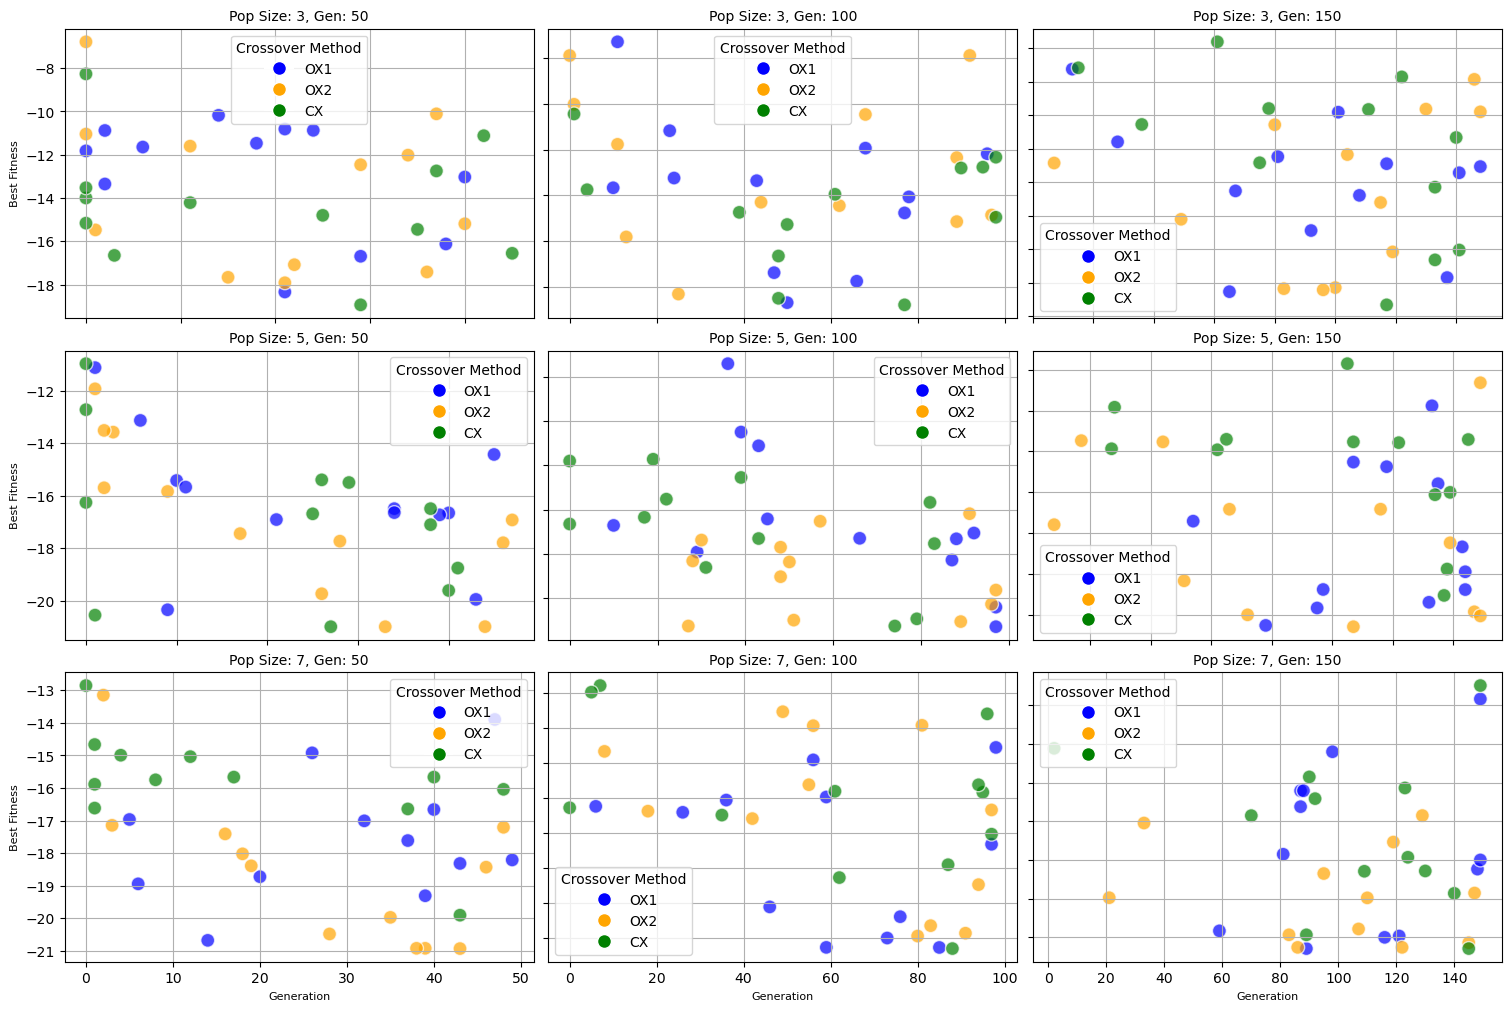

In [23]:
import matplotlib.pyplot as plt

crossover_colors = {
    "OX1": "blue",
    "OX2": "orange",
    "CX": "green"
}

df['color'] = df['crossover_method'].map(crossover_colors)

unique_population_sizes = df['population_size'].unique()
unique_n_generations = df['n_generations'].unique()

num_rows = len(unique_population_sizes)
num_cols = len(unique_n_generations)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10), constrained_layout=True)


for i, pop_size in enumerate(unique_population_sizes):
    for j, n_gen in enumerate(unique_n_generations):
        subset = df[(df['population_size'] == pop_size) & (df['n_generations'] == n_gen)]
        
        if not subset.empty:
            axs[i, j].scatter(
                subset['generation'], 
                subset['best_fitness'], 
                c=subset['color'], 
                s=100, 
                alpha=0.7, 
                edgecolors='w'
            )
            legend_labels = list(crossover_colors.keys())
            handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                                markerfacecolor=crossover_colors[label], markersize=10) for label in legend_labels]
            axs[i, j].legend(handles=handles, title='Crossover Method')
            axs[i, j].set_title(f'Pop Size: {pop_size}, Gen: {n_gen}', fontsize=10)
            axs[i, j].set_xlabel('Generation', fontsize=8)
            axs[i, j].set_ylabel('Best Fitness', fontsize=8)
            axs[i, j].grid()

for ax in axs.flat:
    ax.label_outer()

plt.show()


## Ordenando pela melhor aptidão e menor número de gerações necessários para alcançar

In [24]:
df.sort_values(['best_fitness', 'generation'], ascending=[True, True])

,population_size,n_generations,crossover_method,mutation_method,mutation_probability,generation,best_fitness,color
278,7,100,CX,SWAP,0.20,88,-21.289183,green
146,5,100,OX1,SWAP,0.20,97,-21.286720,blue
194,5,150,OX2,SWAP,0.20,107,-21.286720,orange
295,7,150,OX1,INVERSION,0.10,89,-21.286533,blue
320,7,150,CX,INVERSION,0.20,145,-21.286533,green
...,...,...,...,...,...,...,...,...
55,3,100,OX2,INVERSION,0.10,92,-9.880522,orange
153,5,100,OX1,SHUFFLE,0.05,36,-9.406669,blue
42,3,100,OX1,INVERSION,0.05,11,-9.283866,blue
34,3,50,CX,SHUFFLE,0.10,0,-8.266640,green
